In [5]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

CELL_SIZE = (8, 8)
BLOCK_SIZE = (2, 2)
TARGET_IMG_SIZE = (64, 128)
N_BINS = 9
ANGLE_MAX = 180


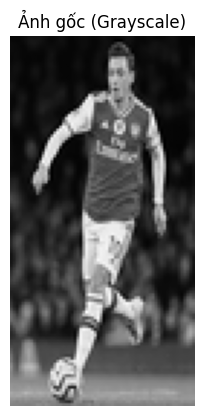

In [6]:
def load_and_preprocess_image(image_path, target_size=TARGET_IMG_SIZE):
    
    img = Image.open(image_path)
    img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
    img_gray = img_resized.convert('L')
    return np.array(img_gray, dtype=float) / 255.0

image_path = "/home/an/an_workplace/Lab_CV/Data/ozil.png"  
img = load_and_preprocess_image(image_path)

plt.imshow(img, cmap='gray')
plt.title("Ảnh gốc (Grayscale)")
plt.axis("off")
plt.show()


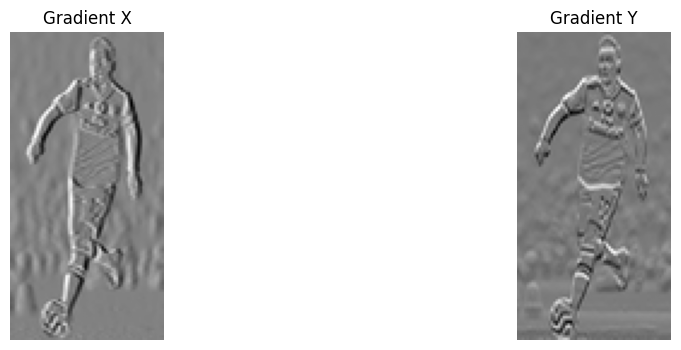

In [7]:
def compute_gradients(image):
    image = image.astype(np.float32)
    gx = np.zeros_like(image)
    gy = np.zeros_like(image)

    gx[:, 1:-1] = (image[:, 2:] - image[:, :-2]) / 2.0
    gx[:, 0] = image[:, 1] - image[:, 0]
    gx[:, -1] = image[:, -1] - image[:, -2]

    gy[1:-1, :] = (image[2:, :] - image[:-2, :]) / 2.0
    gy[0, :] = image[1, :] - image[0, :]
    gy[-1, :] = image[-1, :] - image[-2, :]

    return gx, gy

gx, gy = compute_gradients(img)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(gx, cmap='gray')
plt.title("Gradient X")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(gy, cmap='gray')
plt.title("Gradient Y")
plt.axis("off")
plt.show()


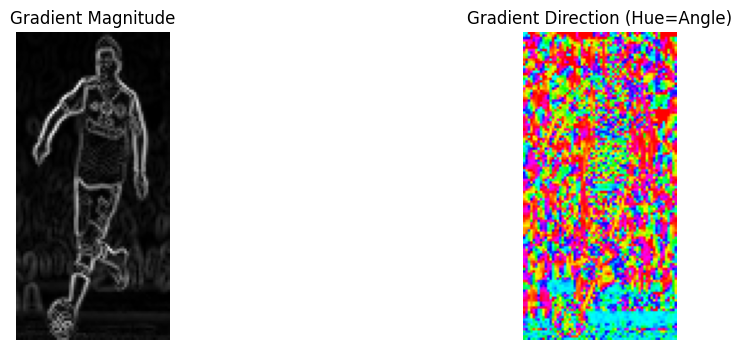

In [8]:
def compute_magnitude_and_direction(gx, gy):
    magnitude = np.sqrt(gx**2 + gy**2)
    direction = np.rad2deg(np.arctan2(gy, gx)) % ANGLE_MAX
    return magnitude, direction

magnitude, direction = compute_magnitude_and_direction(gx, gy)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(magnitude, cmap='gray')
plt.title("Gradient Magnitude")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(direction, cmap='hsv')
plt.title("Gradient Direction (Hue=Angle)")
plt.axis("off")
plt.show()


In [9]:
def compute_cell_histograms(magnitude, direction, cell_size=CELL_SIZE, n_bins=N_BINS):
    h, w = magnitude.shape
    cell_rows = h // cell_size[1]
    cell_cols = w // cell_size[0]
    bin_width = ANGLE_MAX / n_bins
    histograms = np.zeros((cell_rows, cell_cols, n_bins))

    for i in range(cell_rows):
        for j in range(cell_cols):
            mag_cell = magnitude[i*cell_size[1]:(i+1)*cell_size[1], j*cell_size[0]:(j+1)*cell_size[0]]
            dir_cell = direction[i*cell_size[1]:(i+1)*cell_size[1], j*cell_size[0]:(j+1)*cell_size[0]]

            for y in range(cell_size[1]):
                for x in range(cell_size[0]):
                    mag = mag_cell[y, x]
                    ang = dir_cell[y, x]
                    bin_idx = int(ang // bin_width) % n_bins
                    histograms[i, j, bin_idx] += mag
    return histograms

cell_hist = compute_cell_histograms(magnitude, direction)
print("Kích thước lưới cell:", cell_hist.shape[:2])


Kích thước lưới cell: (16, 8)


##Chuẩn hoá Block và Tạo Vector HOG

In [10]:
def normalize_blocks(cell_hist, block_size=BLOCK_SIZE, eps=1e-5):
    n_rows, n_cols, n_bins = cell_hist.shape
    block_rows = n_rows - block_size[0] + 1
    block_cols = n_cols - block_size[1] + 1
    hog_vector = []

    for i in range(block_rows):
        for j in range(block_cols):
            block = cell_hist[i:i+block_size[0], j:j+block_size[1], :].ravel()
            norm = np.linalg.norm(block) + eps
            block_normalized = block / norm
            hog_vector.extend(block_normalized)

    return np.array(hog_vector)

hog = normalize_blocks(cell_hist)
print("Vector HOG thu được:", hog.shape)


Vector HOG thu được: (3780,)


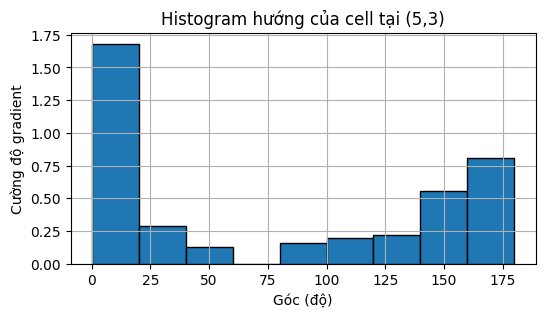

In [11]:
def plot_cell_histogram(cell_hist, row, col):
    bin_range = np.linspace(0, ANGLE_MAX, N_BINS, endpoint=False)
    hist = cell_hist[row, col]
    
    plt.figure(figsize=(6, 3))
    plt.bar(bin_range, hist, width=ANGLE_MAX / N_BINS, align='edge', edgecolor='black')
    plt.title(f"Histogram hướng của cell tại ({row},{col})")
    plt.xlabel("Góc (độ)")
    plt.ylabel("Cường độ gradient")
    plt.grid(True)
    plt.show()

plot_cell_histogram(cell_hist, 5, 3)  


In [ ]:
def visualize_hog_overlay(img, cell_hist, cell_size=CELL_SIZE):
    import matplotlib.pyplot as plt

    h, w = img.shape
    n_cells_y, n_cells_x, n_bins = cell_hist.shape
    bin_angles = np.linspace(0, 180, n_bins, endpoint=False)

    cx, cy = np.meshgrid(np.arange(n_cells_x), np.arange(n_cells_y))
    cx = cx * cell_size[0] + cell_size[0] // 2
    cy = cy * cell_size[1] + cell_size[1] // 2

    plt.figure(figsize=(6, 12))
    plt.imshow(img, cmap='gray')
    for i in range(n_cells_y):
        for j in range(n_cells_x):
            hist = cell_hist[i, j]
            for b, mag in enumerate(hist):
                angle = np.deg2rad(bin_angles[b])
                dx = np.cos(angle) * mag
                dy = -np.sin(angle) * mag
                plt.arrow(cx[i, j], cy[i, j], dx, dy, color='red', head_width=1, alpha=0.5)
    plt.title("HOG hướng theo cell")
    plt.axis("off")
    plt.show()


IndexError: index 8 is out of bounds for axis 1 with size 8

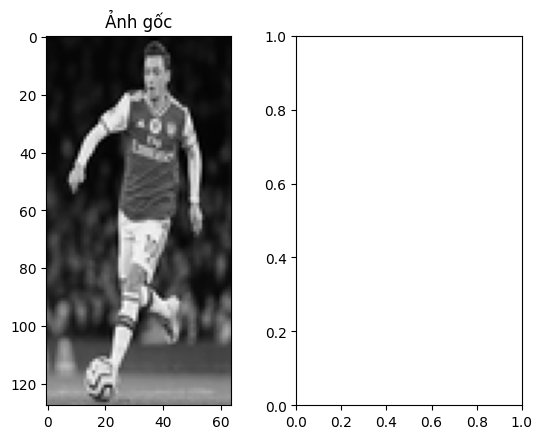

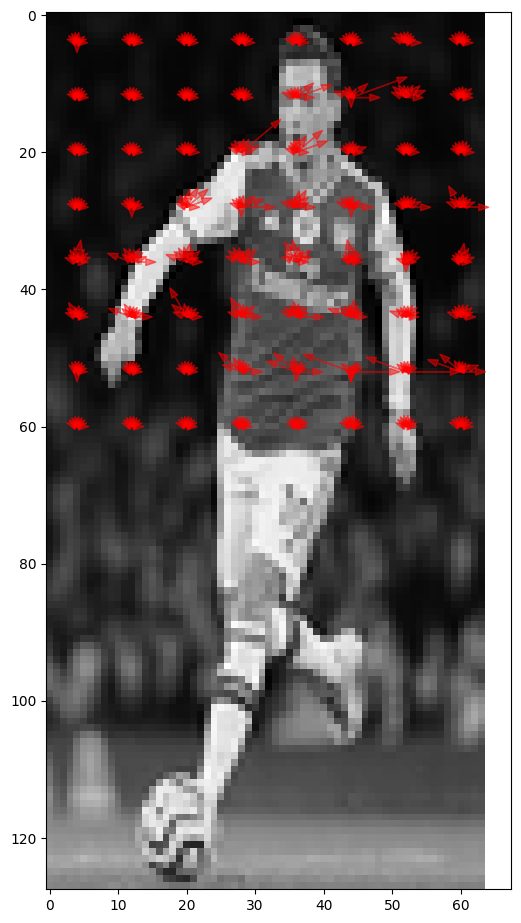

In [16]:
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Ảnh gốc")

plt.subplot(1,2,2)
visualize_hog_overlay(img, cell_hist)
